# Lab 3: Classification (Part 2) and Model Selection

### Due September 14th, 2021 11:59 PM

**Logistics and Lab Submission**

See the course website. Remember that all labs count equally, despite the labs being graded from a different number of total points).

**What You Will Need To Know For This Lab**

This lab covers a few more basic classifiers which can be used for M-ary classification:
- Naive Bayes
- Logistic Regression
- Support Vector Machines

as well as cross-validation, a tool for model selection and assessment.
 
The submission procedure is provided below:
- You will be provided with a template Python script (main.py) for this lab where you need to implement the provided functions as needed for each question. Follow the instructions provided in this Jupyter Notebook (.ipynb) to implement the required functions. **Do not change the file name or the function headers!**
- Upload only your Python script (.py file) on Gradescope. Don't upload your datasets or Jupyter Notebook (.ipynb file).
- Your grades and feedbacks will appear on Gradescope. The grading for the programming questions is automated using Gradescope autograder, no partial credits are given. Therefore, if you wish, you will have a chance to re-submit your code **within 72 hours** of receiving your first grade for this lab, only if you have *reasonable* submissions before the deadline (i.e. not an empty script).
- If you re-submit, the final grade for the programming part of this lab will be calculated as .4 \* first_grade + .6 \* .9 \* re-submission_grade.
- This lab also has Multiple Choice Questions (MCQs) that are needed to be completed on Gradescope **within the deadline**.

There are some problems which have short answer questions. They are not graded, but we are free to discuss answers to these problems. **Multiple Choice Questions (MCQs) will be graded on Gradescope!**

Remember in many applications, the end goal is not always "run a classifier", like in a homework problem, but is to use the output of the classifier in the context of the problem at hand (e.g. detecting spam, identifying cancer, etc.). Because of this, some of our Engineering Design-type questions are designed to get you to think about the entire design problem at a high level.


**Warning: Do not train on your test sets. You will automatically have your score halved for a problem if you train on your test data.**

**Preamble (don't change this)**

In [19]:
%pylab inline
import numpy as np
from sklearn import neighbors
from sklearn import svm
from sklearn import model_selection
from numpy import genfromtxt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import glob

Populating the interactive namespace from numpy and matplotlib


You can copy the following lines during debugging:

In [20]:
%run main.py
q1 = Question1()
q2 = Question2()
q3 = Question3()

### Problem 1: Spam Detection (70 points)

In this problem, you will be constructing a crude spam detector. As you all know, when you receive an e-mail, it can be divided into one of two types: ham (useful mail, label $-1$) and spam (junk mail, label $+1$). In the [olden days](http://www.paulgraham.com/spam.html), people tried writing a bunch of rules to detect spam. However, it was quickly seen that machine learning approaches work fairly well for a little bit of work. 

You will be designing a spam detector by applying some of the classification techniques you learned in class to a batch of emails used to train and test [SpamAssassin](http://spamassassin.apache.org/), a leading anti-spam software package. 

Let the *vocabulary* of a dataset be a list of all terms occuring in a data set. So, for example, a vocabulary could be ["cat","dog","chupacabra", "aerospace", ...]. 

Our features will be based only the frequencies of terms in our vocabulary occuring in the e-mails (such an approach is called a *bag of words* approach, since we ignore the positions of the terms in the emails). The $j$-th feature is the number of times term $j$ in the vocabulary occurs in the email. If you are interested in further details on this model, you can see Chapters 6 and 13 in [Manning's Book](http://nlp.stanford.edu/IR-book/).

You will use the following classifiers in this problem:
- sklearn.naive_bayes.BernoulliNB (Naive Bayes Classifier with Bernoulli Model)
- sklearn.naive_bayes.MultinomialNB (Naive Bayes Classifier with Multinomial Model)
- sklearn.svm.LinearSVC (Linear Support Vector Machine)
- sklearn.linear_model.LogisticRegression (Logistic Regression)
- sklearn.neighbors.KNeighborsClassifier (1-Nearest Neighbor Classifier)

In the context of the Bernoulli Model for Naive Bayes, scikit-learn will binarize the features by interpretting the $j$-th feature to be $1$ if the $j$-th term in the vocabulary occurs in the email and $0$ otherwise. This is a categorical Naive Bayes model, with binary features. While we did not discuss the multinomial model in class, it operates directly on the frequencies of terms in the vocabulary, and is discussed in Section 13.2 in [Manning's Book](http://nlp.stanford.edu/IR-book/) (though you do not need to read this reference). Both the Bernoulli and Multinomial models are commonly used for Naive Bayes in text classification. 

A sample Ham email is:

    From nic@starflung.com  Mon Jun 24 17:06:54 2002
    Return-Path: 7910726.0.27May2002215326@mp.opensrs.net
    Delivery-Date: Tue May 28 02:53:28 2002
    Received: from mp.opensrs.net (mp.opensrs.net [216.40.33.45]) by
        dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g4S1rSe14718 for
        <zzz@spamassassin.taint.org>; Tue, 28 May 2002 02:53:28 +0100
    Received: (from popensrs@localhost) by mp.opensrs.net (8.9.3/8.9.3) id
        VAA04361; Mon, 27 May 2002 21:53:26 -0400
    Message-Id: <7910726.0.27May2002215326@mp.opensrs.net>
    Date: Mon, 27 May 2002 21:53:26 -0500 (EST)
    From: "Starflung NIC" <nic@starflung.com>
    To: <zzz@spamassassin.taint.org>
    Subject: Automated 30 day renewal reminder 2002-05-27
    X-Keywords: 

    The following domains that are registered as belonging
    to you are due to expire within the next 60 days. If
    you would like to renew them, please contact
    nic@starflung.com; otherwise they will be deactivated
    and may be registered by another.


    Domain Name, Expiry Date
    nutmegclothing.com, 2002-06-26
    
    
A sample Spam email is: 

    From jjj@mymail.dk  Fri Aug 23 11:03:31 2002
    Return-Path: <jjj@mymail.dk>
    Delivered-To: zzzz@localhost.example.com
    Received: from localhost (localhost [127.0.0.1])
        by phobos.labs.example.com (Postfix) with ESMTP id 478B54415C
        for <zzzz@localhost>; Fri, 23 Aug 2002 06:02:57 -0400 (EDT)
    Received: from mail.webnote.net [193.120.211.219]
        by localhost with POP3 (fetchmail-5.9.0)
        for zzzz@localhost (single-drop); Fri, 23 Aug 2002 11:02:57 +0100 (IST)
    Received: from smtp.easydns.com (smtp.easydns.com [205.210.42.30])
        by webnote.net (8.9.3/8.9.3) with ESMTP id IAA08912;
        Fri, 23 Aug 2002 08:13:36 +0100
    From: jjj@mymail.dk
    Received: from mymail.dk (unknown [61.97.34.233])
        by smtp.easydns.com (Postfix) with SMTP
        id 7484A2F85C; Fri, 23 Aug 2002 03:13:31 -0400 (EDT)
    Reply-To: <jjj@mymail.dk>
    Message-ID: <008c61d64eed$6184e5d5$4bc22de3@udnugg>
    To: bbr_hooten@yahoo.com
    Subject: HELP WANTED.  WORK FROM HOME REPS.
    MiME-Version: 1.0
    Content-Type: text/plain;
        charset="iso-8859-1"
    X-Priority: 3 (Normal)
    X-MSMail-Priority: Normal
    X-Mailer: Microsoft Outlook, Build 10.0.2616
    Importance: Normal
    Date: Fri, 23 Aug 2002 03:13:31 -0400 (EDT)
    Content-Transfer-Encoding: 8bit

    Help wanted.  We are a 14 year old fortune 500 company, that is
    growing at a tremendous rate.  We are looking for individuals who
    want to work from home.

    This is an opportunity to make an excellent income.  No experience
    is required.  We will train you.

    So if you are looking to be employed from home with a career that has
    vast opportunities, then go:

    http://www.basetel.com/wealthnow

    We are looking for energetic and self motivated people.  If that is you
    than click on the link and fill out the form, and one of our
    employement specialist will contact you.

    To be removed from our link simple go to:

    http://www.basetel.com/remove.html


    1349lmrd5-948HyhJ3622xXiM0-290VZdq6044fFvN0-799hUsU07l50



First, we will load the data. Our dataset has a bit over 9000 emails, with about 25% of them being spam. We will use 50% of them as a training set, 25% of them as a validation set and 25% of them as a test set. 

In [21]:
# Get list of emails
spamfiles=glob.glob('./Data/Spam/*')
hamfiles=glob.glob('./Data/Ham/*')

In [22]:
import os
spamfiles = ['./Data/Spam/'+i for i in os.listdir('./Data/Spam/')]
hamfiles = ['./Data/Ham/'+i for i in os.listdir('./Data/Ham/')]

In [23]:
# First, we will split the files into the training, validation and test sets.

np.random.seed(seed=222017) # seed the RNG for repeatability
# The autograder will use a different seed.

fnames=np.asarray(spamfiles+hamfiles)
nfiles=fnames.size
labels=np.ones(nfiles)
labels[len(spamfiles):]=-1

# Randomly permute the files we have
idx=np.random.permutation(nfiles)
fnames=fnames[idx]
labels=labels[idx]
#Split the file names into which set they belong to
tname=fnames[:int(nfiles/2)]
trainlabels=labels[:int(nfiles/2)]
vname=fnames[int(nfiles/2):int(nfiles*3/4)]
vallabels=labels[int(nfiles/2):int(nfiles*3/4)]
tename=fnames[int(3/4*nfiles):]
testlabels=labels[int(3/4*nfiles):]

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

# Get our Bag of Words Features from the data
bow = CountVectorizer(input='filename',encoding='iso-8859-1',binary=False)
traindata=bow.fit_transform(tname)
valdata=bow.transform(vname)
testdata=bow.transform(tename)

The $100$ most and least common terms in the vocabulary are:

In [25]:
counts=np.reshape(np.asarray(np.argsort(traindata.sum(axis=0))),-1)
vocab=np.reshape(np.asarray(bow.get_feature_names()),-1)
print ("100 most common terms: " , ','.join(str(s) for s in vocab[counts[-100:]]), "\n")
print ("100 least common terms: " , ','.join(str(s) for s in vocab[counts[:100]]))

100 most common terms:  slashnull,dogma,ist,thu,not,lists,cnet,mail,wed,as,html,have,click,jmason,exmh,00,are,align,freshrpms,or,mailman,date,text,mon,message,12,postfix,type,arial,users,bgcolor,ie,rpm,linux,version,22,be,taint,your,mailto,sourceforge,admin,content,20,color,table,jm,on,aug,border,127,example,face,href,this,nbsp,gif,09,subject,10,img,src,sep,it,that,0100,spamassassin,height,esmtp,is,size,xent,fork,you,tr,www,in,list,11,br,width,received,localhost,id,of,and,org,by,with,net,for,td,http,2002,font,from,3d,to,the,com 

100 least common terms:  g6mn17405760,e17titx,e17tvdy,e17ueb2,e17vjs8,e17vjsf,e17w5r4,e17wchv,e17wcmr,s4tkh2qxhrdntbervcuydvpgt4frugzlf3xwvohcrdtxohcfpaziiaed0ne9lw5,e17wosd,e17wosk,e17wssb,e17titf,e17wsyl,e17xbmd,e17xd4y,e17xlhj,e17yawz,s4lyze220qd,e17yozl,e17ysm1,e17ysna,e17ysox,e17ywux,e17z5re,e17z65d,e17wved,e17tfo0,e17texc,e17stjj,e17kazn,e17kb3f,e17kb3l,e17kba2,e17kcfg,e17kkxb,e17kxx7,e17kxxd,e17lk0h,e17lzkx,e17m2xi,e17mbzo,e17mpr7,e17n4br,e17n8od,e17nmu

We will have our training data in `traindata` (with labels in `trainlabels`), validation data in `valdata` (with labels in `vallabels`) and test data in `testdata` (with labels in `testlabels`).

For each of the following classifiers **(10 points each)**:
- sklearn.naive_bayes.BernoulliNB (Naive Bayes Classifier with Bernoulli Model)
- sklearn.naive_bayes.MultinomialNB (Naive Bayes Classifier with Multinomial Model)
- sklearn.svm.LinearSVC (Linear Support Vector Machine)
- sklearn.linear_model.LogisticRegression (Logistic Regression)
- sklearn.neighbors.KNeighborsClassifier (as a 1-Nearest Neighbor Classifier)

In *main.py*, you are required to finish the followings:
1. Train on the training data in `traindata` with corresponding labels `trainlabels`. Use the default parameters, unless otherwise noted.
2. Report Training Error.
3. Report Validation Error.
4. Report the time it takes to fit the classifier (i.e. time to perform xxx.fit(X,y)).
5. Report the time it takes to run the classifier on the validation data (i.e. time to perform xxx.predict(X,y)).

You can ignore all convergence issues. After you finish all parts above, you can retrieve your performances as followed:

In [26]:


q1 = Question1()
classifier_list = ["BernoulliNB", "MultinomialNB", "LinearSVC", "LogisticRegression", "NN"]
for name in classifier_list:
    _, trainingError, validationError, fittingTime, valPredictingTime = eval("q1." + name + "_classifier(traindata, trainlabels, valdata, vallabels)")
    print(name, "classifier:")
    print("The Training Error is: %.3f" % trainingError)
    print("The Validation Error is: %.3f" % validationError)
    print("The Fitting Time is: %.5f sec" % fittingTime)
    print("The Predicting Time is: %.5f sec" % valPredictingTime)
    print("-----------------------------------------------------------------")

BernoulliNB classifier:
The Training Error is: 0.034
The Validation Error is: 0.055
The Fitting Time is: 0.02200 sec
The Predicting Time is: 0.01400 sec
-----------------------------------------------------------------
MultinomialNB classifier:
The Training Error is: 0.019
The Validation Error is: 0.027
The Fitting Time is: 0.01197 sec
The Predicting Time is: 0.00500 sec
-----------------------------------------------------------------
LinearSVC classifier:
The Training Error is: 0.000
The Validation Error is: 0.011
The Fitting Time is: 0.44800 sec
The Predicting Time is: 0.00300 sec
-----------------------------------------------------------------
LogisticRegression classifier:
The Training Error is: 0.000
The Validation Error is: 0.008
The Fitting Time is: 1.84813 sec
The Predicting Time is: 0.00297 sec
-----------------------------------------------------------------
NN classifier:
The Training Error is: 0.000
The Validation Error is: 0.016
The Fitting Time is: 0.00500 sec
The Predi

**Extra (not evaluated):** Based on the results of this problem and knowledge of the application at hand (spam filtering), pick one of the classifiers in this problem and describe how you would use it as part of a spam filter for the University of Illinois email system. Sketch out a system design at a very high level -- how you would train the spam filter to deal with new threats, would you filter everyone's email jointly, etc. You may get some inspiration from the [girls and boys](https://gmail.googleblog.com/2007/10/how-our-spam-filter-works.html) at [Gmail](https://gmail.googleblog.com/2015/07/the-mail-you-want-not-spam-you-dont.html), the [chimps at MailChimp](http://kb.mailchimp.com/delivery/spam-filters/about-spam-filters) or other places.

Write a function that calculates the confusion matrix (cf. Fig. 2.1 in the notes). You may wish to read Section 2.1.1 in the notes -- it may be helpful, but is not necessary to complete this problem. **(10 points)**

Select a classifier in the previous part of the problem and run the classifier on the test data. The following code displays the test error and the output of the function. **(10 points)**

In [27]:
_, testError, cm = q1.classify(traindata, trainlabels, testdata, testlabels)
print("The Test Error is: %3f" % testError)
print("Confusion matrix for test data:")
print ("True Positives:", cm[0,0], "False Positive:", cm[0,1])
print ("False Negative:", cm[1,0], "True Negatives:", cm[1,1])
print ("True Positive Rate : ", cm[0,0]/(cm[0,0] + cm[1,0]))
print ("False Positive Rate: ", cm[0,1]/(cm[0,1] + cm[1,1]))

The Test Error is: 0.008982
Confusion matrix for test data:
True Positives: 616.0 False Positive: 17.0
False Negative: 4.0 True Negatives: 1701.0
True Positive Rate :  0.9935483870967742
False Positive Rate:  0.00989522700814901


As a sanity check, you should observe that your true positive rate is above 0.95 (i.e. highly sensitive).

### Problem 2: Cross-Validation (45 Points)

Now, we will load some data (acquired from <a href="http://www.cs.ubc.ca/~murphyk/">K.P. Murphy</a>'s <a href="https://github.com/probml/pmtk3"> PMTK tookit</a>).

In [28]:
problem2_tmp= genfromtxt('Data/p2.csv', delimiter=',')

# Randomly reorder the data
np.random.seed(seed=2217) # seed the RNG for repeatability
# The autograder will use a different seed.

idx=np.random.permutation(problem2_tmp.shape[0])
problem2_tmp=problem2_tmp[idx]

#The training data which you will use is called "traindata"
traindata=problem2_tmp[:500,:2]
#The training labels are in "labels"
trainlabels=problem2_tmp[:500,2]

#The test data which you will use is called "testdata" with labels "testlabels"
testdata=problem2_tmp[500:,:2]
testlabels=problem2_tmp[500:,2]

**You should not re-shuffle your data in your functions!**

Write function *splitCVSet* which splits the training data and labels in $5$-fold to help future cross-validation.

You will be given as input:
* A $(N,d)$ numpy.ndarray of training data, *trainData* (with $N$ divisible by 5)
* A length $N$ numpy.ndarray of training labels, *trainLabels*

This function has two outputs:
* A ((4/5)$N$, $d$, 5) numpy.ndarray, *trainDataCV*
* A ((4/5)$N$, 5) numpy.ndarray, *trainLabelsCV*

**For this problem, take your folds to be 0:(1/5)N, (1/5)N:(2/5)N, ..., (4/5)N:N for cross-validation** (In general, however, the folds should be randomly divided.) Therefore, *trainDataCV[:,:,i]* and *trainLabelsCV[:,i]* should correspond to the training features and labels for the $i$-th fold (i.e., with subset (i/5)N:((i+1)/5)N removed from the input). Do NOT use any other features of scikit-learn, such as things from sklearn.model_selection. <b>(10 points)</b>

Hint: Use numpy.delete

Write function *crossValidationkNN* which implements $5$-fold cross-validation to estimate the error of a classifier with cross-validation with the 0,1-loss for k-Nearest Neighbors (kNN). You should use the outputs from the previous function *splitCVSet*.

You will be given as input:
* A ((4/5)$N$, $d$, 5) numpy.ndarray, *trainDataCV*, from the previous function
* A ((4/5)$N$, 5) numpy.ndarray, *trainLabelsCV*, from the previous function
* A number $k$, for which cross-validated error estimates will be outputted for $1,\ldots,k$

Your output will be a vector (represented as a numpy.ndarray) *err*, such that *err[i]* is the cross-validated estimate of using i neighbors (*err* will be of length $k+1$; the zero-th component of the vector will not be used). You should use scikit-learn's *sklearn.neighbors.KNeighborsClassifier* to perform the training and classification for the kNN models involved. <b>(15 points)</b>

Write function *minimizer_K* that **inputs the result of the above function** and returns 1) the number of neighbors within $1,\ldots,30$ that minimizes the cross-validation error, and 2) the correponding minimum error. <b>(10 points)</b>

The following code helps you to visualize your result. It plots the cross-validation error with respect to the number of neighbors. Your best number of neighbors should be roughly at the middle of your err array.

The best number of neighbors is: 20
The corresponding error is: 0.20400000000000001


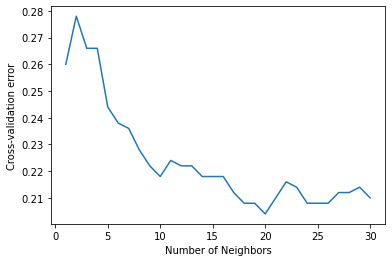

In [29]:
%run main.py
# q1 = Question1()
q2 = Question2()
# q3 = Question3()
trainDataCV, trainLabelsCV = q2.splitCVSet(traindata,trainlabels)
kNN_errors = q2.crossValidationkNN(traindata,trainlabels,trainDataCV,trainLabelsCV,30)
k_min, err_min = q2.minimizer_K(kNN_errors)
plot(np.arange(1,31),kNN_errors[1:])
xlabel('Number of Neighbors')
ylabel('Cross-validation error')
axis('tight')
print("The best number of neighbors is:", k_min)
print("The corresponding error is:", err_min)

Train a kNN model on the whole training data using the number of neighbors you found in the previous part of the question, and apply it to the test data. **(10 points)**

In [30]:
_, testError = q2.classify(traindata, trainlabels, testdata, testlabels)
print("The test error is:", testError)

The test error is: 0.17500000000000004


As a sanity check, the test error should be around 0.2.

### Problem 3: Detecting Cancer with SVMs and Logistic Regression (35 points)

We consider the [Breast Cancer Wisconsin Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29) from 
W.N. Street, W.H. Wolberg and O.L. Mangasarian. Nuclear feature extraction for breast tumor diagnosis. IS&T/SPIE 1993 International Symposium on Electronic Imaging: Science and Technology, volume 1905, pages 861-870, San Jose, CA, 1993. 

The authors diagnosed people by characterizing 3 cell nuclei per person extracted from the breast (pictures [here](http://web.archive.org/web/19970225174429/http://www.cs.wisc.edu/~street/images/)), each with 10 features (for a 30-dimensional feature space):

1. radius (mean of distances from center to points on the perimeter) 

2. texture (standard deviation of gray-scale values) 

3. perimeter 

4. area 

5. smoothness (local variation in radius lengths) 

6. compactness (perimeter^2 / area - 1.0) 

7. concavity (severity of concave portions of the contour) 

8. concave points (number of concave portions of the contour) 

9. symmetry 

10. fractal dimension ("coastline approximation" - 1)

and classified the sample into one of two classes: Malignant ($+1$) or Benign ($-1$). You can read the original paper for more on what these features mean.

You will be attempting to classify if a sample is Malignant or Benign using Support Vector Machines, as well as Logistic Regression. Since we don't have all that much data, we will use **10-fold** cross-validation to tune our parameters for our SVMs and Logistic Regression. We use 90% of the data for training, and 10% for testing.

You will be experimenting with SVMs using Gaussian RBF kernels (through sklearn.svm.SVC), linear SVMs (through sklearn.svm.LinearSVC), and Logistic Regression (sklearn.linear_model.LogisticRegression). 

Your model selection will be done with cross-validation via sklearn.model_selection's *cross_val_score*. This returns the accuracy for each fold, i.e. the fraction of samples classified correctly. Thus, the cross-validation error is simply 1-mean(cross_val_score). **Remember to change the default fold number (i.e., cv)!**

First, we load the data. We will use scikit-learn's train test split function to split the data. The data is scaled for reasons outlined <a href="http://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf">here</a>. In short, it helps avoid some numerical issues and avoids some problems with certain features which are typically large affecting the SVM optimization problem unfairly compared to features which are typically small. 

In [31]:
cancer = genfromtxt('Data/wdbc.csv', delimiter=',')

np.random.seed(seed=282017) # seed the RNG for repeatability
# The autograder will use a different seed.

idx=np.random.permutation(cancer.shape[0])
cancer=cancer[idx]

cancer_features=cancer[:,1:]
cancer_labels=cancer[:,0]

#The training data is in data_train with labels label_train. 
# The test data is in data_test with labels label_test.
data_train, data_test, label_train, label_test = train_test_split(cancer_features,cancer_labels,test_size=0.1,random_state=292017)

# Rescale the training data and scale the test data correspondingly
scaler=MinMaxScaler(feature_range=(-1,1))
data_train=scaler.fit_transform(data_train) #Note that the scaling is determined solely via the training data!
data_test=scaler.transform(data_test)
q3 = Question3()

The following lines ignore the warnings.

In [32]:
import warnings
warnings.filterwarnings("ignore")

The soft margin linear SVM is tuned based on a parameter $C$, which controls how much points can be violating the margin (this isn't the same $C$ as in the notes, though it serves the same function; see the [scikit-learn documentation](http://scikit-learn.org/stable/modules/svm.html#svc) for details). 

Use cross-validation to select a value of $C$ for a linear SVM (sklearn.svm.LinearSVC) by varying $C$ from $2^{-5},2^{-4},\ldots,2^{15}$. <b>(10 points)</b>

In [33]:
 %run main.py
#  q1 = Question1()
#  q2 = Question2()
 q3 = Question3()
C_min, min_err = q3.LinearSVC_crossValidation(data_train, label_train)
print("Soft Margin Linear SVM:")
print("The best C is:", C_min)
print("The corresponding error is:", min_err)

Soft Margin Linear SVM:
The best C is: 0.25
The corresponding error is: 0.025339366515837014


<Figure size 432x288 with 0 Axes>

You will now experiment with using kernels in an SVM, particularly the Gaussian RBF kernel (in sklearn.svm.SVC). The SVM has two parameters to tune in this case: $C$ (as before), and $\gamma$, which is a parameter in the RBF. 

Use cross-validation to select parameters $(C,\gamma)$ by searching varying $(C,\gamma)$ over $C=2^{-5},2^{-4},\ldots,2^{15}$ and $\gamma=2^{-15},\ldots,2^{3}$ [So, you will try about 400 parameter choices]. This procedure is known as a **grid search**. You can choose to use *GridSearchCV* (see doc [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)) to perform a grid search (and you can use *clf.best\_params
_['xxx']* to get the best parameters). Note that we are using 10-fold cross-validation.

Think about it: Out of these, which $(C,\gamma)$ parameters would you choose? What is the corresponding cross-validation error?

We are using a fairly coarse grid for this problem, but in practice one could use a finer grid once the rough range of good parameters is known (rather than starting with a fine grid, which would waste a lot of time). <b>(10 points)</b>

In [34]:
C_min, gamma_min, min_err = q3.SVC_crossValidation(data_train, label_train)
print("SVM with RBF kernel:")
print("The best C is:", C_min)
print("The best gamma is:", gamma_min)
print("The corresponding error is:", min_err)

SVM with RBF kernel:
The best C is: 8
The best gamma is: 0.125
The corresponding error is: 0.0195324283559577


As stated in a footnote in the notes, Logistic Regression normally has a regularizer parameter to promote stability. Scikit-learn calls this parameter $C$ (which is like $\lambda^{-1}$ in the notes); see the [LibLinear](http://www.csie.ntu.edu.tw/~cjlin/papers/liblinear.pdf) documentation for the exact meaning of $C$. 

Use cross-validation to select a value of $C$ for logistic regression (sklearn.linear_model.LogisticRegression) by varying $C$ from $2^{-14},\ldots,2^{14}$. You may optionally make use of *sklearn.model_selection.GridSearchCV*, or write the search by hand. **(5 points)**

In [35]:
C_min, min_err = q3.LogisticRegression_crossValidation(data_train, label_train)
print("Logistic Regression:")
print("The best C is:", C_min)
print("The corresponding error is:", min_err)

Logistic Regression:
The best C is: 1
The corresponding error is: 0.021455505279034726


Train the classifier selected above on the whole training set. Then, estimate the prediction error using the test set. What is your estimate of the prediction error? How does it compare to the cross-validation error?  <b>(10 points)</b>

In [36]:
_, error = q3.classify(data_train, label_train, data_test, label_test)
print("The prediction error is:", error)

The prediction error is: 0.01754385964912286


Note that there could be some problem with the data, so don't be surprised by your answer above (in some cases).

**Extra (not evaluated):** Below are a few questions for you think about to further your understanding of these classifiers. These will not be graded. You could discuss these with other students or the TAs during the office hours.

1. Based on the classifiers you selected thusfar for Linear SVM, SVM + Gaussian RBF and Logistic Regression, which classifier would you pick? Make sure to take into account error, the application and computational considerations. 

2. Do you think the 0,1-loss is appropriate performance measure to report, in this case? If so, why? If not, how would you measure performance? 

## And this concludes Lab 3! Congratulations!